In [3]:
#9章　GLMのベイズモデル化と事後分布の推定

#この教科書の実装はR言語によるものとなっている。
#それをPythonにて実装しなおす

#########この章の簡単な説明######
"""""
これまでの章では、架空の植物についてGLMやGLMMを用いてモデリングした。
ここから、これまでのモデルをベイズモデル化してより柔軟な推計を行う。
"""""
import pandas as pd
import pyper as pr
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf 

#Rdataはpyperを使用して読み込む
r = pr.R(use_numpy='True', use_pandas='True')
r('load(url("http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/gibbs/d.RData"))')
rdata = pd.DataFrame(r.get("d"))
rdata.columns = ["x", "y"]
rdata.head()

,x,y
0,3.000000,5.0
1,3.210526,3.0
2,3.421053,6.0
3,3.631579,7.0
4,3.842105,7.0


In [4]:
#個体差なしのGLM(ポアソン回帰)

model1 = smf.glm(formula="y  ~ x",data=rdata,family=sm.families.Poisson())
res1 = model1.fit()
print('Parameters: ', res1.params)
print(res1.summary())
print(res1.summary2())

Parameters:  Intercept    1.566056
x            0.083341
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45.018
Date:                Tue, 09 Oct 2018   Deviance:                       14.171
Time:                        18:21:08   Pearson chi2:                     13.6
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5661      0.360      4.351      0.000     

In [3]:
#GLMのベイズモデル化
#モデル:パラメータは定数項αとxにかかるβの二つ。この二つはそれぞれ無情報事前分布(平均0標準偏差100の正規分布)を設定
#yはポアソン分布に従うものとする。
#pymcを使って実装を試す

In [5]:
import pymc3 as pm

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    lam= np.exp(alpha + beta * rdata["x"])
    Y_obs = pm.Poisson('Y_obs', lam, observed=rdata["y"])
    
#下記はNUTSというサンプリング方法
#その他メトロポリス法などが指定できる
with model:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(1600, step, start,njobs=3)
    

logp = -56.642, ||grad|| = 71.531: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 369.86it/s]
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, alpha]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 6300/6300 [00:32<00:00, 195.09draws/s]
C:\Users\hirou\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001516C47AF98>,
      dtype=object)

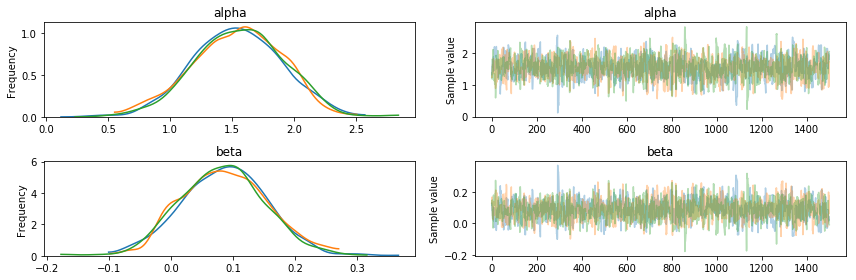

In [6]:
pm.traceplot(trace[100:])

In [7]:
pm.summary(trace[100:])

C:\Users\hirou\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.546234,0.357510,0.009574,0.790614,2.173320,1326.724110,1.000606
beta,0.085850,0.067719,0.001818,-0.041306,0.221025,1333.903681,1.000641


In [ ]:
#それぞれのパラメータの平均はそれぞれ約0.15と約0.08であり、教科書の数値と大きくは変わらない。MAP推定量はGLMの結果とだいたい同じになっている。